In [1]:
import pandas as pd 
import numpy as np
from datetime import datetime, timezone

In [2]:
# run this to read_feather
#!pip install pyarrow

In [3]:
df=pd.read_feather('RC_2012_year_cohort.feather')

In [4]:
df.count()

created_utc    234225454
author         234225454
subreddit      234225454
dtype: int64

In [5]:
df.head()

,created_utc,author,subreddit
0,1325376000,irwinator,AskReddit
1,1325376000,reed311,politics
2,1325376000,sagapo3851,gaming
3,1325376000,filthgrinder,politics
4,1325376001,BitterDivorcedDad,WTF


## Q1: Find random 30 subreddits

#### Note: Top 30 results in a dead kernel. so changed to 40:70.

In [6]:
cat = list(df['subreddit'].value_counts()[40:70].index)

In [7]:
df=df[df['subreddit'].isin(cat)]

In [8]:
df.subreddit.unique()

['relationships', 'MensRights', 'SquaredCircle', 'sex', 'hockey', ..., 'motorcycles', 'masseffect', 'TheLastAirbender', 'SubredditDrama', 'dayz']
Length: 30
Categories (30, object): ['relationships', 'MensRights', 'SquaredCircle', 'sex', ..., 'masseffect', 'TheLastAirbender', 'SubredditDrama', 'dayz']

In [9]:
df.count()

created_utc    16472752
author         16472752
subreddit      16472752
dtype: int64

## Q2: Filter the dataframe so you are only looking at data form a single sub-reddit.

In [10]:
def sub_df(subreddit):
    subreddit=str(subreddit)
    new_df=df[df['subreddit']==subreddit]
    new_df=new_df[['created_utc','author']]
    return new_df   

In [11]:
sub_df('dayz')

,created_utc,author
64024078,1335137991,KiwiThunda
64052935,1335141654,LKS
64053161,1335141682,KiwiThunda
64115615,1335149008,KiwiThunda
64138533,1335151548,LKS
...,...,...
234221834,1354319678,[deleted]
234221890,1354319682,trahh
234222682,1354319755,[deleted]
234223750,1354319846,trahh


## 3. Find the date of first interaction (for that sub-reddit)

In [12]:
def first_post_df(subreddit): 
    t1=sub_df(subreddit)
    t1['date']=pd.to_datetime(t1['created_utc'], unit='s')
    t1["author"] = t1["author"].astype(str)
    
    first_date=t1.groupby(['author'])['date'].agg('min')
    first_date=pd.DataFrame(first_date)
    first_date.reset_index(inplace=True)
    first_date.rename(columns={'date':'first_date'},inplace=True)
    
    result= t1.merge(first_date,on='author',how="left")
    result.drop('date',axis=1,inplace=True)
    
    return result
    

In [13]:
first_post_df('dayz')

,created_utc,author,first_date
0,1335137991,KiwiThunda,2012-04-22 23:39:51
1,1335141654,LKS,2012-04-23 00:40:54
2,1335141682,KiwiThunda,2012-04-22 23:39:51
3,1335149008,KiwiThunda,2012-04-22 23:39:51
4,1335151548,LKS,2012-04-23 00:40:54
...,...,...,...
431721,1354319678,[deleted],2012-04-23 20:57:49
431722,1354319682,trahh,2012-07-22 18:55:18
431723,1354319755,[deleted],2012-04-23 20:57:49
431724,1354319846,trahh,2012-07-22 18:55:18


##  4. Combine the initial dataframe with the dataframe containing comment timestamps

In [14]:
def detailed_df(subreddit):
    result=first_post_df(subreddit)
    
    result['comment_date']=pd.to_datetime(result['created_utc'], unit='s').dt.date
    result['first_date']=result['first_date'].dt.date
    result['day_since']=result['comment_date']-result['first_date']
    result['day_since'] = result['day_since'].apply(lambda x: x.days)
    
    return result[["author","day_since"]].drop_duplicates()

In [15]:
detailed_df("dayz")

,author,day_since
0,KiwiThunda,0
1,LKS,0
2,KiwiThunda,1
5,bfoo,0
8,TALIHAM,0
...,...,...
431694,XxPikachuxX,9
431706,awfulrob,132
431709,IHAZZ3RI,0
431710,RoninKengo,145


## 5. Pivot the dataframe so the names of authors are on one axis and the days on which they commented are on the second axis

In [16]:
def sparse_matrix(subreddit):
    df = detailed_df(subreddit).pivot(columns="author",values="day_since", index = "day_since").applymap(lambda x: 0 if pd.isna(x) else 1)
    return df

In [17]:
# example 
sparse_matrix("dayz")

author,---blade---,-CerN-,-DASH-,-DickFart,-Gavin-,-HeartShapedBox-,-HippoMan-,-Jayus-,-KAIZO-,-Manchee-,...,zysion,zyth3x,zzTopo,zzephyr,zziob,zzorga,zzoyx1,zzubnik,zzyxxy,zzzacs
day_since,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,0,0,0,1,0,0,0,1,1,0,...,0,1,1,0,0,1,0,0,0,1
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
3,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
218,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
219,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 6. Sum the number of commenters for each day

In [18]:
def number_of_comenters(subreddit):
    res = sparse_matrix(subreddit).sum(axis = 1)
    
    return res

In [19]:
# example 
number_of_comenters("dayz")

day_since
0      31805
1       5346
2       3798
3       3366
4       3155
       ...  
217        5
218        4
219        3
220        2
221        2
Length: 222, dtype: int64

## 7. Calculate the % of authors who returned after their first comment


In [20]:
def percent_returned(subreddit):
    res = 100 * (sparse_matrix(subreddit).sum(axis = 1))/number_of_comenters(subreddit).iloc[0]
    
    return res

In [21]:
percent_returned("dayz")

day_since
0      100.000000
1       16.808678
2       11.941519
3       10.583242
4        9.919824
          ...    
217      0.015721
218      0.012577
219      0.009432
220      0.006288
221      0.006288
Length: 222, dtype: float64

## 8. Display this series on a chart

In [22]:
# list out all topics
topics = df.subreddit.unique()

In [23]:
# generate cohort matrix function
def cohort_matrix(topics):
    matrix = pd.DataFrame()
    
    for i in range(0,len(topics)):
        matrix = matrix.append(percent_returned(topics[i]), ignore_index = True)
    matrix = matrix.transpose()
    matrix.columns = topics
    return matrix

In [24]:
# generate cohort matrix of all topics
cohortMatrix = cohort_matrix(topics)
cohortMatrix

,relationships,MensRights,SquaredCircle,sex,hockey,SteamGameSwap,Drugs,askscience,tf2,Libertarian,...,canada,news,DebateReligion,keto,gameofthrones,motorcycles,masseffect,TheLastAirbender,SubredditDrama,dayz
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,12.974977,13.358280,16.193071,10.628223,12.571605,22.353601,11.353795,7.986060,11.695172,12.377575,...,10.447083,7.328258,22.473571,16.397229,9.938263,16.119533,17.823118,13.817927,11.820608,16.808678
2,5.187835,6.557306,11.054885,4.634448,8.579360,11.931094,5.352140,3.163522,7.223181,6.209895,...,4.998254,2.999175,12.799818,10.170061,5.686302,8.810466,12.581265,9.114737,5.261926,11.941519
3,3.845076,4.755896,9.718438,3.534728,7.473341,9.382804,4.056291,2.399991,6.075109,4.951874,...,3.856095,2.261763,10.378538,8.754986,4.797382,7.067684,10.843521,7.752510,4.194560,10.583242
4,3.297627,4.068401,9.692487,3.072005,6.975412,7.782478,3.578706,2.097736,5.593912,4.483283,...,3.471883,1.865542,8.718881,8.074743,4.351762,6.638023,10.038026,6.914501,4.157109,9.919824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,0.118542,0.308937,1.634877,0.072113,0.414206,0.183477,0.140092,0.096992,0.279826,0.531915,...,0.468041,0.122902,0.477435,0.142767,0.034814,0.400695,0.085865,0.011075,0.046814,NaN
331,0.099144,0.291533,1.466200,0.082930,0.334890,0.188573,0.120988,0.083458,0.292902,0.443262,...,0.398184,0.117399,0.443333,0.138568,0.025530,0.362074,0.065421,0.011075,0.065540,NaN
332,0.099144,0.204508,1.115869,0.054085,0.365735,0.137608,0.105069,0.076691,0.240598,0.375718,...,0.317848,0.084380,0.386495,0.113374,0.025530,0.337936,0.061332,0.014767,0.037451,NaN
333,0.053883,0.147942,0.973141,0.051681,0.282013,0.173284,0.079598,0.048496,0.190910,0.287065,...,0.258470,0.055031,0.284188,0.104976,0.018568,0.212417,0.044977,0.007383,0.028089,NaN


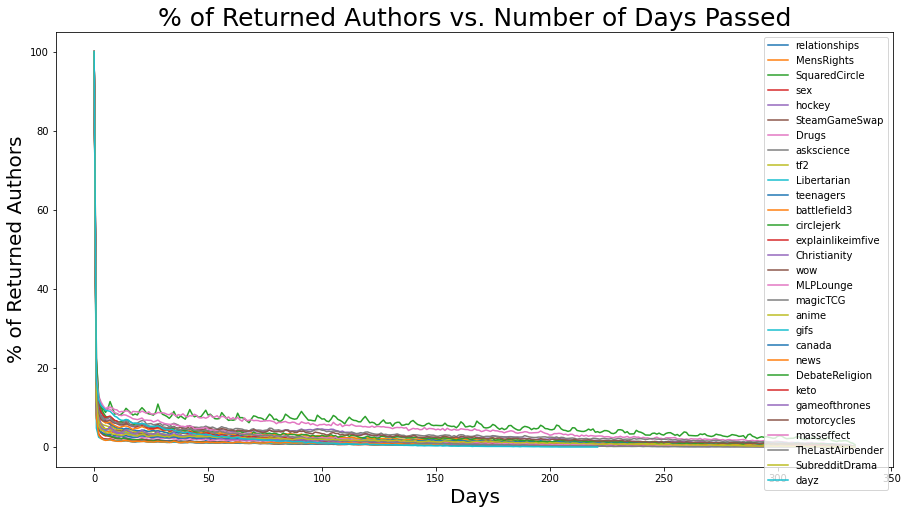

In [25]:
# Retention Curve Chart
import matplotlib as plt

ax = cohortMatrix.plot(kind='line', figsize=(15, 8))
ax.set_title('% of Returned Authors vs. Number of Days Passed', fontsize=25)
ax.set_xlabel("Days").set_size(20)
ax.set_ylabel("% of Returned Authors").set_size(20)

##  Retention Curve Chart Zoom In Version for better view.

(0.0, 22.4735705354098)

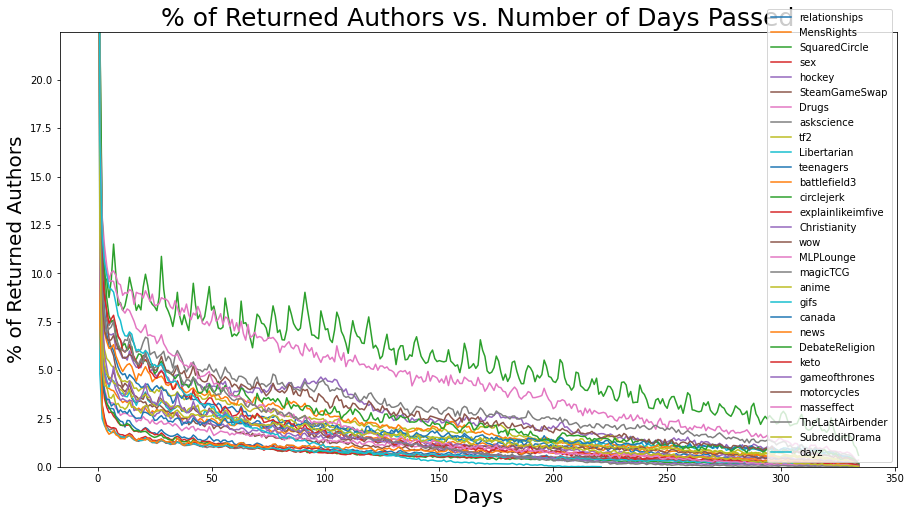

In [26]:

import matplotlib as plt

ax = cohortMatrix.plot(kind='line', figsize=(15, 8))
ax.set_title('% of Returned Authors vs. Number of Days Passed', fontsize=25)
ax.set_xlabel("Days").set_size(20)
ax.set_ylabel("% of Returned Authors").set_size(20)

# the y range set to 0-27 because the highest value in Day1 is 26.36
maxVal = max(cohortMatrix.iloc[1])
ax.set_ylim([0, maxVal])